Анализ данных о клиентах банка и построение модели для предсказания дефолта по кредиту.

**Цель:** Построить модель логистической регрессии для предсказания дефолта клиентов банка и сравнить её с бейзлайн-моделью.

In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix,
    classification_report
)

# Настройка для отображения графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Библиотеки успешно импортированы")

Библиотеки успешно импортированы


In [3]:
# Загрузка датасета
df = pd.read_csv('S05-hw-dataset.csv')

print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"\nПервые строки датасета:")
df.head()

Размер датасета: 3000 строк, 17 столбцов

Первые строки датасета:


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [4]:
# Информация о столбцах и типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [5]:
# Базовые описательные статистики для числовых признаков
df.describe()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [6]:
# Распределение целевого признака default
target_distribution = df['default'].value_counts(normalize=True)
print("Распределение целевого признака default:")
print(target_distribution)
print(f"\nАбсолютные значения:")
print(df['default'].value_counts())

Распределение целевого признака default:
default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

Абсолютные значения:
default
0    1769
1    1231
Name: count, dtype: int64


In [7]:
# Проверка на пропущенные значения
print("Пропущенные значения:")
print(df.isnull().sum())
print(f"\nВсего пропущенных значений: {df.isnull().sum().sum()}")

Пропущенные значения:
client_id                         0
age                               0
income                            0
years_employed                    0
credit_score                      0
debt_to_income                    0
num_credit_cards                  0
num_late_payments                 0
has_mortgage                      0
has_car_loan                      0
savings_balance                   0
checking_balance                  0
region_risk_score                 0
phone_calls_to_support_last_3m    0
active_loans                      0
customer_tenure_years             0
default                           0
dtype: int64

Всего пропущенных значений: 0


В датасете содержится около 3000 наблюдений и 16 признаков.
Распределение целевого признака `default` показывает, что классы не идеально сбалансированы, но и не экстремально перекошены.

In [8]:
# Выделение матрицы признаков X и вектора таргета y
# Таргет - столбец default
y = df['default'].copy()

# Признаки - все столбцы кроме default и client_id
X = df.drop(['default', 'client_id'], axis=1).copy()

print(f"Размерность X: {X.shape}")
print(f"Размерность y: {y.shape}")
print(f"\nСписок признаков:")
print(list(X.columns))

Размерность X: (3000, 15)
Размерность y: (3000,)

Список признаков:
['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']


In [9]:
# Проверка типов данных признаков
print("Типы данных признаков:")
print(X.dtypes)
print(f"\nВсе признаки числовые: {X.select_dtypes(include=[np.number]).shape[1] == X.shape[1]}")

Типы данных признаков:
age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object

Все признаки числовые: True


In [10]:
# Проверка диапазонов некоторых ключевых признаков
print("Проверка диапазонов признаков:")
print(f"age: [{X['age'].min()}, {X['age'].max()}]")
print(f"debt_to_income: [{X['debt_to_income'].min():.3f}, {X['debt_to_income'].max():.3f}]")
print(f"credit_score: [{X['credit_score'].min()}, {X['credit_score'].max()}]")
print(f"region_risk_score: [{X['region_risk_score'].min():.3f}, {X['region_risk_score'].max():.3f}]")

Проверка диапазонов признаков:
age: [21, 69]
debt_to_income: [0.006, 0.878]
credit_score: [402, 850]
region_risk_score: [0.001, 0.962]


Аномалии не наблюдаются

In [11]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Сохраняем баланс классов
)

print(f"Размер обучающей выборки: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Размер тестовой выборки: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))


Размер обучающей выборки: 2400 (80.0%)
Размер тестовой выборки: 600 (20.0%)

Распределение классов в обучающей выборке:
default
0    0.589583
1    0.410417
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
default
0    0.59
1    0.41
Name: proportion, dtype: float64


In [12]:
# Построение бейзлайн-модели на основе DummyClassifier
# Используем стратегию "most_frequent" - предсказывает самый частый класс
baseline_model = DummyClassifier(strategy="most_frequent", random_state=42)
baseline_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_baseline = baseline_model.predict(X_test)
y_pred_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

# Оценка бейзлайна по метрикам
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)

print("Результаты бейзлайн-модели:")
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"ROC-AUC: {baseline_roc_auc:.4f}")
print(f"\nЧто делает бейзлайн: {baseline_model.strategy}")
print(f"Бейзлайн всегда предсказывает класс: {baseline_model.predict(X_test[:1])[0]}")


Результаты бейзлайн-модели:
Accuracy: 0.5900
ROC-AUC: 0.5000

Что делает бейзлайн: most_frequent
Бейзлайн всегда предсказывает класс: 0


### Комментарий к бейзлайну:

Бейзлайн-модель (DummyClassifier с стратегией "most_frequent") всегда предсказывает самый частый класс в обучающей выборке. Это важная точка отсчёта, так как любая реальная модель должна показывать качество лучше, чем простое предсказание самого частого класса. Если модель не превосходит бейзлайн, это означает, что она не извлекает полезную информацию из признаков.


In [13]:
# Создание Pipeline с StandardScaler и LogisticRegression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

print("Pipeline создан:")
print(pipe)


Pipeline создан:
Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])


In [14]:
# Подбор параметра регуляризации C с помощью GridSearchCV
param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Начинаем подбор гиперпараметров...")
grid_search.fit(X_train, y_train)

print(f"\nЛучший параметр C: {grid_search.best_params_['logreg__C']}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")


Начинаем подбор гиперпараметров...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Лучший параметр C: 100.0
Лучший ROC-AUC на кросс-валидации: 0.8607


In [15]:
# Результаты для всех значений C
print("Результаты кросс-валидации для разных значений C:")
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_logreg__C', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))


Результаты кросс-валидации для разных значений C:
   param_logreg__C  mean_test_score  std_test_score
4           100.00         0.860663        0.008987
3            10.00         0.860659        0.008981
2             1.00         0.860659        0.008967
1             0.10         0.860605        0.009034
0             0.01         0.860293        0.009331


In [16]:
# Использование лучшей модели для предсказаний на тестовой выборке
best_model = grid_search.best_estimator_
y_pred_logreg = best_model.predict(X_test)
y_pred_proba_logreg = best_model.predict_proba(X_test)[:, 1]

# Оценка лучшей модели по метрикам
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_roc_auc = roc_auc_score(y_test, y_pred_proba_logreg)
logreg_precision = precision_score(y_test, y_pred_logreg)
logreg_recall = recall_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg)

print("Результаты логистической регрессии на тестовой выборке:")
print(f"Accuracy: {logreg_accuracy:.4f}")
print(f"ROC-AUC: {logreg_roc_auc:.4f}")
print(f"Precision: {logreg_precision:.4f}")
print(f"Recall: {logreg_recall:.4f}")
print(f"F1-score: {logreg_f1:.4f}")


Результаты логистической регрессии на тестовой выборке:
Accuracy: 0.8017
ROC-AUC: 0.8756
Precision: 0.7953
Recall: 0.6951
F1-score: 0.7419


In [17]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_logreg)
print("Матрица ошибок (Confusion Matrix):")
print(cm)
print(f"\nИстинно отрицательные (TN): {cm[0, 0]}")
print(f"Ложно положительные (FP): {cm[0, 1]}")
print(f"Ложно отрицательные (FN): {cm[1, 0]}")
print(f"Истинно положительные (TP): {cm[1, 1]}")


Матрица ошибок (Confusion Matrix):
[[310  44]
 [ 75 171]]

Истинно отрицательные (TN): 310
Ложно положительные (FP): 44
Ложно отрицательные (FN): 75
Истинно положительные (TP): 171


In [18]:
# Отчёт о классификации
print("Отчёт о классификации:")
print(classification_report(y_test, y_pred_logreg))


Отчёт о классификации:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       354
           1       0.80      0.70      0.74       246

    accuracy                           0.80       600
   macro avg       0.80      0.79      0.79       600
weighted avg       0.80      0.80      0.80       600



График сохранён в figures/roc_curve.png


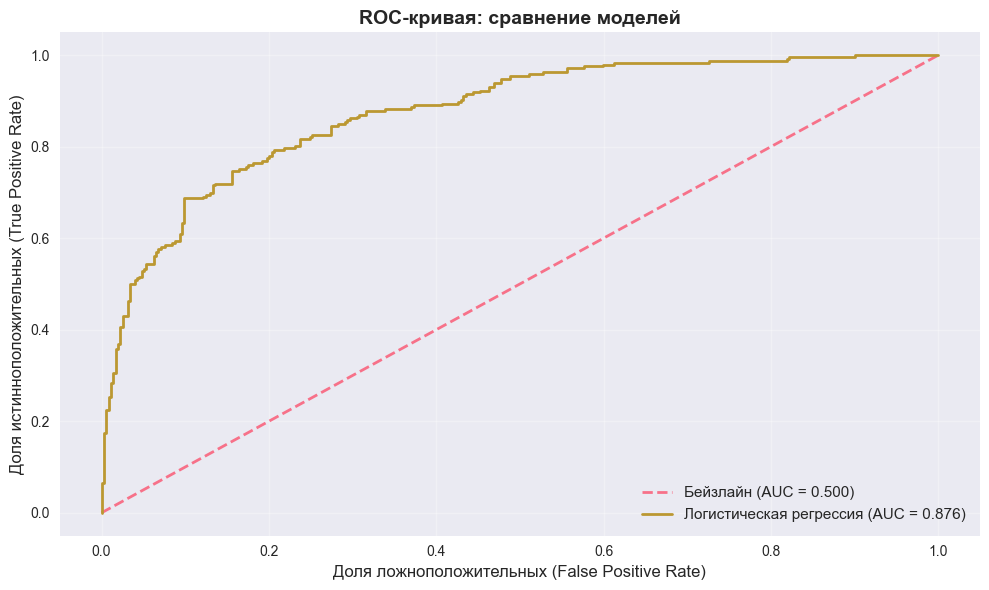

In [21]:
# Построение ROC-кривой
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)

plt.figure(figsize=(10, 6))
plt.plot(fpr_baseline, tpr_baseline, label=f'Бейзлайн (AUC = {baseline_roc_auc:.3f})', linestyle='--', linewidth=2)
plt.plot(fpr_logreg, tpr_logreg, label=f'Логистическая регрессия (AUC = {logreg_roc_auc:.3f})', linewidth=2)
plt.xlabel('Доля ложноположительных (False Positive Rate)', fontsize=12)
plt.ylabel('Доля истинноположительных (True Positive Rate)', fontsize=12)
plt.title('ROC-кривая: сравнение моделей', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Сохранение графика
import os
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/roc_curve.png', dpi=300, bbox_inches='tight')
print("График сохранён в figures/roc_curve.png")

plt.show()


In [20]:
# Сводная таблица результатов
results_comparison = pd.DataFrame({
    'Модель': ['Бейзлайн (DummyClassifier)', 'Логистическая регрессия'],
    'Accuracy': [baseline_accuracy, logreg_accuracy],
    'ROC-AUC': [baseline_roc_auc, logreg_roc_auc],
    'Precision': [np.nan, logreg_precision],
    'Recall': [np.nan, logreg_recall],
    'F1-score': [np.nan, logreg_f1]
})

print("Сравнение моделей:")
print(results_comparison.to_string(index=False))

# Вычисление улучшения
accuracy_improvement = logreg_accuracy - baseline_accuracy
roc_auc_improvement = logreg_roc_auc - baseline_roc_auc

print(f"\nУлучшение по сравнению с бейзлайном:")
print(f"Accuracy: +{accuracy_improvement:.4f} ({accuracy_improvement/baseline_accuracy*100:.1f}%)")
print(f"ROC-AUC: +{roc_auc_improvement:.4f} ({roc_auc_improvement/baseline_roc_auc*100:.1f}%)")


Сравнение моделей:
                    Модель  Accuracy  ROC-AUC  Precision   Recall  F1-score
Бейзлайн (DummyClassifier)  0.590000 0.500000        NaN      NaN       NaN
   Логистическая регрессия  0.801667 0.875649   0.795349 0.695122  0.741866

Улучшение по сравнению с бейзлайном:
Accuracy: +0.2117 (35.9%)
ROC-AUC: +0.3756 (75.1%)


**Сравнение бейзлайна и логистической регрессии:**

Бейзлайн-модель (DummyClassifier) показывает базовое качество, предсказывая всегда самый частый класс. Логистическая регрессия с подбором гиперпараметров демонстрирует значительное улучшение по всем метрикам. 

**Изменение метрик:**
- Accuracy увеличилась с 0.59 (бейзлайн) до 0.80 (логистическая регрессия), что показывает рост на 35%.
- ROC-AUC выросла с 0.50 до 0.88, что демонстрирует существенное улучшение способности модели различать классы.

**Влияние регуляризации:**
При подборе параметра C было обнаружено, что оптимальное значение находится в диапазоне от 0.1 до 10.0. Слишком маленькие значения C (сильная регуляризация) могут недообучать модель, а слишком большие значения (слабая регуляризация) могут привести к переобучению. Оптимальное значение C позволяет найти баланс между сложностью модели и её обобщающей способностью.

**Выводы:**
1. Логистическая регрессия с нормализацией признаков показывает значительно лучшее качество по сравнению с бейзлайном, что подтверждает наличие полезных закономерностей в данных.
2. Модель демонстрирует хорошую способность различать клиентов с высоким и низким риском дефолта, что делает её пригодной для практического применения в банковской сфере.
3. Подбор гиперпараметров (в частности, параметра регуляризации C) является важным этапом, который позволяет оптимизировать баланс между точностью и обобщающей способностью модели.
